<a href="https://colab.research.google.com/github/efidvir/WirelessRL/blob/master/transmit_wait_agent_quinary_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "gym>=0.21.0"
!pip install tf-agents


     |████████████████████████████████| 1.5 MB 29.5 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=5da66d131df6b9fd65cf75de2d0e1b791ea6ba6b1805b022ad4b67a0fd1e1637
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 1.3 MB 21.2 MB/s 


In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
import os
import copy
import sys      
import time

import threading
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import torch
import tensorflow as tf
#from gnuradio import gr
#import pmt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax
from tensorflow.keras.layers import Dense

from gym import Env
from gym.spaces import Discrete, Box


#from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
#from matplotlib.figure import Figure
#from PyQt5 import QtCore #conda install pyqt
#from PyQt5 import QtWidgets

import abc
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent

import copy

In [3]:
HISTORY_BUFFER_LEN = 200
DEFAULT_WINDOW_SIZE = 3
EPISODE_LENGTH = 20
NUMBER_OF_EPISODES = 50
seed = 8


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))
num_GPU = 1        
if num_GPU < len(gpus):
  tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
  print('Only GPU number', num_GPU, 'used')

tf.random.set_seed(seed)

Number of GPUs available : 0


In [5]:
class transmit_wait():
  def __init__(self, sensed = 0 , window_size = DEFAULT_WINDOW_SIZE, history = 0):
    self._action_spec = Discrete(2) #transmit or not {0,1}
    self.initial_state = history 
    self._state = history
    self.window_size = window_size	
    self.episode_length = EPISODE_LENGTH
    self.reward = 0

  def reset(self):
    self._state = [self.initial_state , self.sensed , 0]
    self._episode_ended = False
    self.episode_length = EPISODE_LENGTH
    self.reward = 0
    return (self.reward , self._state , 0)

  def step(self, action , good_reward):
    #history: collision = 0 , clean transmit = 1 , avoided collision = 2 , wasted slot = 3'
    history = self._state
    count_fairness = 0
    slience = 0
    allow = 0
    collisions = 0
    for i in range(len(history)):
      if history[i] == 1:
        count_fairness += 1
      if history[i] == 3:
        slience += 1
      if history[i] == 2:
        allow += 1  
      if history[i] == 0:
        collisions += 1
        

    if history[-1] == 0 : #collision
      self.reward = self.reward-10*collisions
    elif history[-1] == 1 : #clean transmit
      self.reward = self.reward+2 #-(2-allow)
    elif history[-1] == 2 : #avoided collision
      self.reward = self.reward+1 #-(2-count_fairness)
    elif history[-1] == 3 : #wasted slot
      self.reward = self.reward-3*slience + 4
    
    
    if allow == count_fairness and collisions == 0 and slience == 0:
      self.reward = self.reward + 55 #bonus for fairness
    
    if allow == 4 or count_fairness == 4 or slience == 4 or collisions == 4 :
      self.reward = self.reward - 25 #penlety for lack of fairness
    
    reward = self.reward	#comulative reward
    self.reward = 0

    return(reward)


In [6]:
class DQN_agent():
    	def __init__(self, learning_rate, gamma, window_size):
    		self.nb_actions = 2 #on off
    		self.window_size = window_size
    		self.gamma = gamma
    		self.learning_rate = learning_rate
    		
    		self.history_length = HISTORY_BUFFER_LEN
    		self.history = [[]for i in range(self.history_length)]
    		self.history_idx = 0
    		
    		#Create and initialize the online DQN
    		self.DQN_online = tf.keras.models.Sequential([Dense(self.window_size, activation='relu'), Dense(self.window_size, activation='relu'), Dense(self.nb_actions, activation='softmax') #Outputs positive values 
    		])
    		self.DQN_online.build(input_shape=(None, self.window_size)) #Build the model to create the weights
    		
    		#Create and initialize the offline DQN
    		self.DQN_offline = tf.keras.models.Sequential([Dense(self.window_size, activation='relu'), Dense(self.window_size, activation='relu'), Dense(self.nb_actions, activation='softmax') #Outputs positive values
    		])
    		self.DQN_offline.build(input_shape=(None, self.window_size)) #Build the model to create the weights
    		
    		self.copy_parameters() #Copy the weights of the online network to the offline network
    		
    		self.loss_func = tf.keras.losses.MSE
    		self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
        
    	def choose_action(self, state, epsilon):
    		"""Implements an epsilon-greedy policy"""
    		history = state
    		# Explore ?
    		if np.random.uniform(size=1) < epsilon :
    			action =  np.random.randint(2)


    		#Exploite - Choose the current best action
    		else:    
    			DQN_input = tf.concat(history, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    			outputs = self.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
    			action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)
    		return action
    
    	def learn(self, batch_size):
    		"""Sample experiences from the history and performs SGD"""
    		
    		# Samples random experiences from the history
    		idx = np.random.choice(range(self.history_length), batch_size, replace=False) # Create random indexes 
    		rdm_exp =  [self.history[i] for i in idx] # Take experiences corresponding to the random indexes
    		
    		
    		# Create 4 batches : states_vec, actions, rewards, new states_vec
    		states_vec = np.array([rdm_exp[i][0] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		actions = np.array([rdm_exp[i][1] for i in range(batch_size)]) # Shape : [BS]
    		rewards = np.array([rdm_exp[i][2] for i in range(batch_size)]) # Shape : [BS]
    		n_states_vec = np.array([rdm_exp[i][3] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		
    		#Compute the best q_value for the new states
    		max_n_q_values = tf.reduce_max(self.DQN_offline(n_states_vec), axis=1).numpy()

    		with tf.GradientTape() as tape:
    			#Forward pass through the online network to predict the q_values
    			pred_q_values = self.DQN_online(states_vec)
    			
    			# Compute targets
    			targets = pred_q_values.numpy()
    			targets[np.arange(targets.shape[0]), actions]= rewards +   self.gamma * max_n_q_values
    			
    			# Evaluate the loss
    			self.loss = self.loss_func(pred_q_values, targets)
        
    		# Compute gradients and perform the gradient descent
    		gradients = tape.gradient(self.loss, self.DQN_online.trainable_weights)
    		self.optimizer.apply_gradients(zip(gradients, self.DQN_online.trainable_weights))  
    
    	def insert_history(self, state, action, reward, n_state):
    		"""Insert experience in history"""
        
    		#sensed_ch, curr_ch, end = state
    		history = state
    		state_vec = np.array(history)# Create the state vector for the state
        
    		n_history = n_state
    		n_state_vec = np.array(n_history) # Create the state vector for the new state

    		self.history[self.history_idx] = [state_vec, action, reward, n_state_vec] # Insert everything in the history
        
    		self.history_idx = (self.history_idx+1)%self.history_length # Move the history_idx by one
    
    	def copy_parameters(self):
    		"""Copy the parameters of the online network to the offline network"""

    		weights = self.DQN_online.get_weights()
    		self.DQN_offline.set_weights(weights)		

def combine_state_history(state, history):
  '''state is the sensed channel vector (oocupied or not), history is the actions taken by the agent(transmit or not)'''
  'collision = 0 , clean transmit = 1 , avoided collision = 2 , wasted slot = 3'
  combined = np.zeros(len(state))
  for i in range (len(state)):
    if state[i]==1 and history[i]==1: #sensed ocupied and transmited = collision
      combined[i] = 0
    if state[i]==0 and history[i]==1: #not sensed ocupied and transmited = my sucsess
      combined[i] = 1
    if state[i]==1 and history[i]==0: #sensed ocupied and not transmited = other agent sucsess
      combined[i] = 2
    if state[i]==0 and history[i]==0: #not sensed ocupied and not transmited = wasted slot
      combined[i] = 3
  return combined	

initial step:
agent 1:  [0. 0. 0. 0.]
agent 2:  [0. 0. 0. 1.]
agent 1:::: [0. 0. 0. 1.] :::: state:  [3. 3. 3. 2.] reward:  1
agent 2:::: [0. 0. 0. 0.] :::: state:  [3. 3. 3. 1.] reward:  2
agent 1:::: [0. 0. 1. 0.] :::: state:  [3. 3. 2. 1.] reward:  2
agent 2:::: [0. 0. 0. 1.] :::: state:  [3. 3. 1. 2.] reward:  1
agent 1:::: [0. 1. 0. 0.] :::: state:  [3. 2. 1. 1.] reward:  2
agent 2:::: [0. 0. 1. 1.] :::: state:  [3. 1. 2. 2.] reward:  1
agent 1:::: [1. 0. 0. 0.] :::: state:  [2. 1. 1. 3.] reward:  1
agent 2:::: [0. 1. 1. 0.] :::: state:  [1. 2. 2. 3.] reward:  1
agent 1:::: [0. 0. 0. 0.] :::: state:  [1. 1. 3. 1.] reward:  2
agent 2:::: [1. 1. 0. 1.] :::: state:  [2. 2. 3. 2.] reward:  1
agent 1:::: [0. 0. 0. 1.] :::: state:  [1. 3. 1. 0.] reward:  -10
agent 2:::: [1. 0. 1. 1.] :::: state:  [2. 3. 2. 0.] reward:  -10
agent 1:::: [0. 0. 1. 1.] :::: state:  [3. 1. 0. 0.] reward:  -20
agent 2:::: [0. 1. 1. 1.] :::: state:  [3. 2. 0. 0.] reward:  -20
agent 1:::: [0. 1. 1. 1.] :::: sta

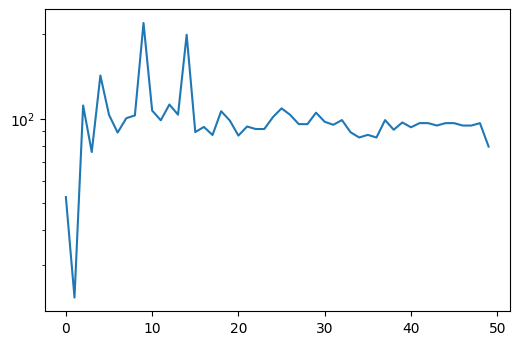

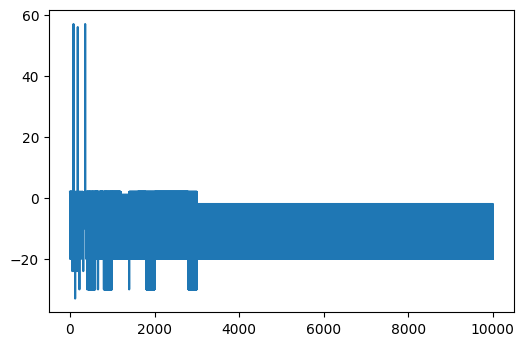

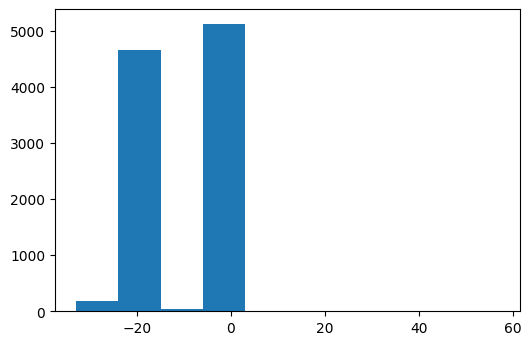

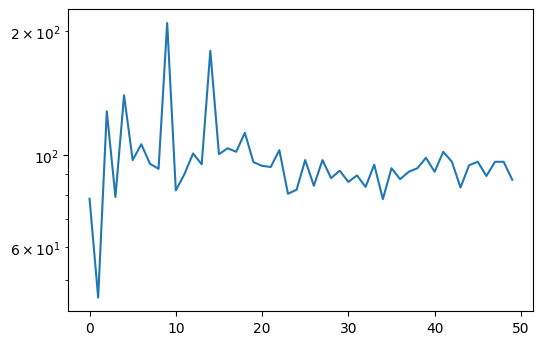

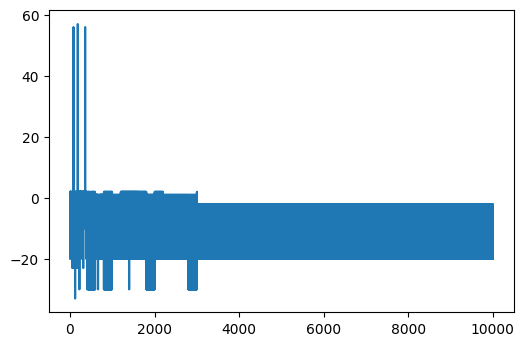

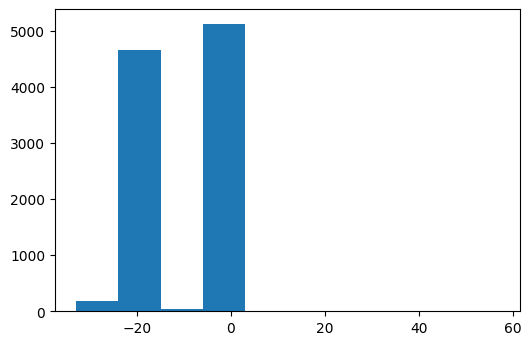

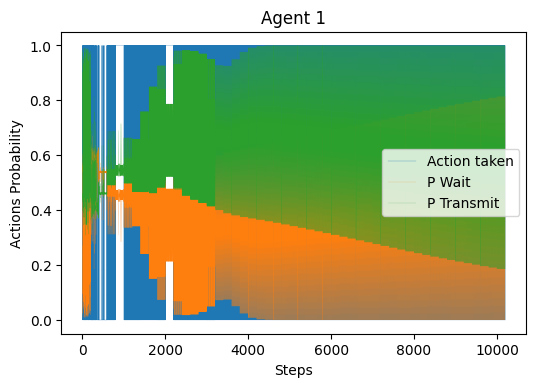

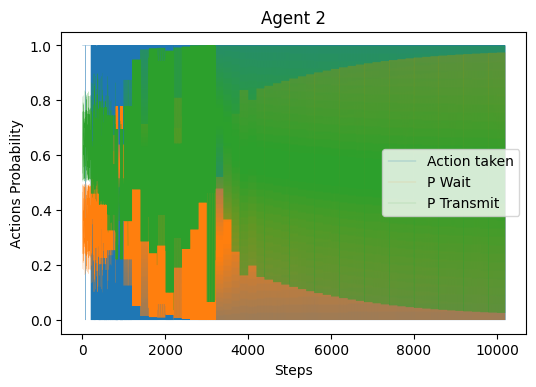

No handles with labels found to put in legend.


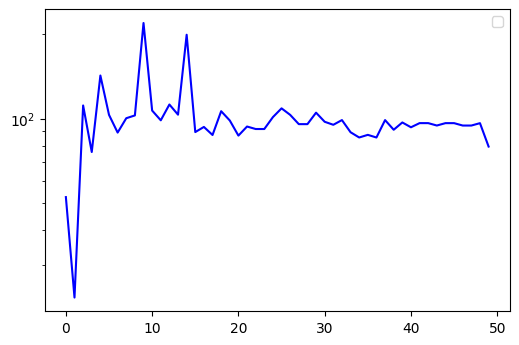

No handles with labels found to put in legend.


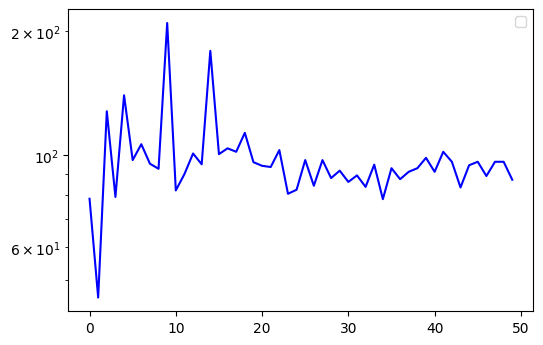

In [7]:
window_size = DEFAULT_WINDOW_SIZE
gamma = 0.8
learning_rate = 0.08
epsilon = 1


losses1 = []
losses2 = []
rewards1 = []
rewards2 = []
for x in range(0,1):
  #learning_rate = learning_rate/100
  #gamma = gamma/10
  good_reward = 3
  loss1 = []
  loss2 = []
  reward_coll1=[]
  reward_coll2=[]
  Q_value_1 = []
  Q_value_2 = []
  actions1 = []
  actions2 = []
  window_size = 4
  "Main code"
  #epsilon=epsilon/10
  #an agent cant hear itself when he is transmitting
  channel_agent1 = np.zeros(window_size)
  channel_agent2 = np.zeros(window_size)
  my_history1 = np.zeros(window_size)
  my_history2 = np.zeros(window_size)
  state1 = np.zeros(window_size)
  state2 = np.zeros(window_size)

  environment1 = transmit_wait(0,window_size, channel_agent1)
  environment2 = transmit_wait(0,window_size, channel_agent2)  

  #Round 1: agent draw actions without prior knowladge 
  agent1 = DQN_agent((learning_rate), (gamma), window_size) #init agent spaces
  agent2 = DQN_agent((learning_rate), (gamma), window_size) #init agent spaces

  prv_state1 = channel_agent1
  prv_state2 = channel_agent2

  #Both take a random action
  prv_action1 = agent1.choose_action(channel_agent1, 1)
  if prv_action1 == 1:
    channel_agent2 = np.append(channel_agent2,1)
  else:
    channel_agent2 = np.append(channel_agent2,0)
  channel_agent2 = np.delete(channel_agent2,0)

  prv_action2 = agent2.choose_action(channel_agent2, 1) 
  if prv_action2 == 1:
    channel_agent1 = np.append(channel_agent1,1)
  else:
    channel_agent1 = np.append(channel_agent1,0)
  channel_agent1 = np.delete(channel_agent1,0)

  #new state
  environment1._state = channel_agent1
  environment2._state = channel_agent2
  


  print('initial step:')
  print('agent 1: ', environment1._state)
  print('agent 2: ', environment2._state)

  #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
  for i in range(0,HISTORY_BUFFER_LEN):
    

    
    #Change states
    'Both take random actions (epsilon = 1)'
    #agent 1
    action1 = agent1.choose_action(environment1._state, 1)
    transmit_prob1  = np.random.randint(11)
    if action1 == 1: #if i transmit or not
      state2 = np.append(state2, 1) #sensed from agent 2
      my_history1 = np.append(my_history1, 1)
    else:
      state2 = np.append(state2, 0) 
      my_history1 = np.append(my_history1, 0)

    state2 = np.delete(state2,0) #pop last in window
    my_history1 = np.delete(my_history1,0) #pop last in window

    #agent 2
    action2 = agent2.choose_action(environment2._state, 1)
    
    if action2 == 1:
      state1 = np.append(state1, 1) 
      my_history2 = np.append(my_history2, 1)
    else:
      state1 = np.append(state1, 0) 
      my_history2 = np.append(my_history2, 0)

    state1 = np.delete(state1,0) #pop last in window
    my_history2 = np.delete(my_history2,0) #pop last in window
    
    #set the new state
    environment1._state = combine_state_history(state1, my_history1)
    environment2._state = combine_state_history(state2, my_history2)
    


    reward1 = environment1.step(prv_action1 , good_reward)
    reward2 = environment2.step(prv_action1 , good_reward)
    print('agent 1::::',state1,'::::','state: ', environment1._state, 'reward: ', reward1)
    print('agent 2::::',state2,'::::','state: ', environment2._state, 'reward: ', reward2)

    agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
    agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
    
    #save PREVIOUS state and action
    prv_action1 = action1
    prv_action2 = action2
    prv_state1 = environment1._state
    prv_state2 = environment2._state 


    DQN_input_coll1 = tf.concat(environment1._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    Q_value_1.append(agent1.DQN_online(DQN_input_coll1).numpy()[0]) #Get the predicted Q values corresponding to the 2 actions
    actions1.append(np.argmax(agent1.DQN_online(DQN_input_coll1).numpy()[0]))
    DQN_input_coll2 = tf.concat(environment2._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    Q_value_2.append(agent2.DQN_online(DQN_input_coll2).numpy()[0]) #Get the predicted Q values corresponding to the 2 actions
    actions2.append(np.argmax(agent2.DQN_online(DQN_input_coll2).numpy()[0]))

  agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent1.copy_parameters() #lower update frequency?


  agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent2.copy_parameters() #lower update frequency?

  for episodes in range(0,NUMBER_OF_EPISODES):
    #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
    for i in range(0,HISTORY_BUFFER_LEN):
      
      epsilon = 0.995*epsilon
      
      #Change states
      'Both take random actions (epsilon = 1)'
      #agent 1
      action1 = agent1.choose_action(environment1._state, epsilon)
      if action1 == 1: #if i transmit or not
        state2 = np.append(state2, 1) #sensed from agent 2
        my_history1 = np.append(my_history1, 1)
      else:
        state2 = np.append(state2, 0) 
        my_history1 = np.append(my_history1, 0)

      state2 = np.delete(state2,0) #pop last in window
      my_history1 = np.delete(my_history1,0) #pop last in window

      #agent 2
      action2 = agent2.choose_action(environment2._state, epsilon)
      if action2 == 1:
        state1 = np.append(state1, 1) 
        my_history2 = np.append(my_history2, 1)
      else:
        state1 = np.append(state1, 0) 
        my_history2 = np.append(my_history2, 0)

      state1 = np.delete(state1,0) #pop last in window
      my_history2 = np.delete(my_history2,0) #pop last in window
      
      #set the new state
      environment1._state = combine_state_history(state1, my_history1)
      environment2._state = combine_state_history(state2, my_history2)


      DQN_input_coll1 = tf.concat(environment1._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
      Q_value_1.append(agent1.DQN_online(DQN_input_coll1).numpy()[0]) #Get the predicted Q values corresponding to the 2 actions
      actions1.append(np.argmax(agent1.DQN_online(DQN_input_coll1).numpy()[0]))
      DQN_input_coll2 = tf.concat(environment2._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
      Q_value_2.append(agent2.DQN_online(DQN_input_coll2).numpy()[0]) #Get the predicted Q values corresponding to the 2 actions
      actions2.append(np.argmax(agent2.DQN_online(DQN_input_coll2).numpy()[0]))

      reward1 = environment1.step(prv_action1, good_reward)
      reward_coll1.append(reward1)
      reward2 = environment2.step(prv_action1, good_reward)
      reward_coll2.append(reward2)

      agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
      agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
      
      #save PREVIOUS state and action
      prv_action1 = action1
      prv_action2 = action2
      prv_state1 = environment1._state
      prv_state2 = environment2._state 
    agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
    agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
    if episodes%10 == 0:
      agent1.copy_parameters()
      agent2.copy_parameters()
      print('episodes: ', episodes)
    loss1.append(tf.reduce_mean(agent1.loss).numpy()) #Save the losses for future visualization
    loss2.append(tf.reduce_mean(agent2.loss).numpy()) #Save the losses for future visualization
  
  losses1.append(loss1)
  losses2.append(loss2)
  rewards1.append(reward_coll1)
  rewards2.append(reward_coll2)
  
  print(losses1)
  print('final step:')
  print('agent 1: ', environment1._state)
  print('agent 2: ', environment2._state)
  print('randomness level:' ,epsilon)

  plt.semilogy(np.arange(len(loss1)), loss1)
  plt.show()
  plt.plot(np.arange(len(reward_coll1)), reward_coll1)
  plt.show()
  counts, bins = np.histogram(reward_coll1)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.show()
  plt.semilogy(np.arange(len(loss2)), loss2)
  plt.show()
  plt.plot(np.arange(len(reward_coll2)), reward_coll2)
  plt.show()
  counts, bins = np.histogram(reward_coll2)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.show()
  plt.plot(range(0,len(Q_value_1)),actions1, linewidth=0.2)
  plt.plot(range(0,len(Q_value_1)),Q_value_1, linewidth=0.1)
  plt.xlabel("Steps")
  plt.ylabel("Actions Probability")
  plt.legend(['Action taken','P Wait','P Transmit'])
  plt.title('Agent 1')
  plt.show()
  plt.plot(range(0,len(Q_value_1)),actions2, linewidth=0.2)
  plt.plot(range(0,len(Q_value_2)),Q_value_2, linewidth=0.1)
  plt.xlabel("Steps")
  plt.ylabel("Actions Probability")
  plt.legend(['Action taken','P Wait','P Transmit'])
  plt.title('Agent 2')
  plt.show()

colors = ['b' ,'r','g', 'y','c', 'm' ,'k','indigo','orange','pink']
for j in range(0,len(losses1)):
  plt.semilogy(np.arange(len(losses1[j])), losses1[j], colors[j])
plt.legend()
plt.show()

for j in range(0,len(losses2)):
  plt.semilogy(np.arange(len(losses2[j])), losses2[j], colors[j])
plt.legend()
plt.show()



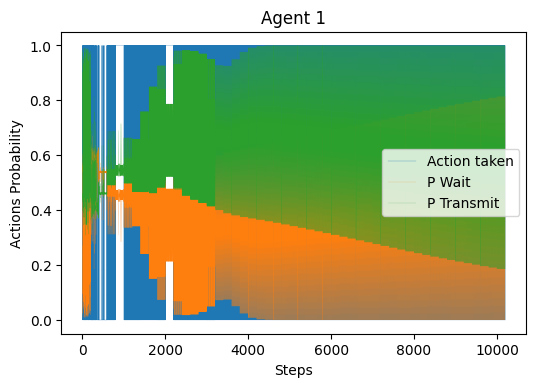

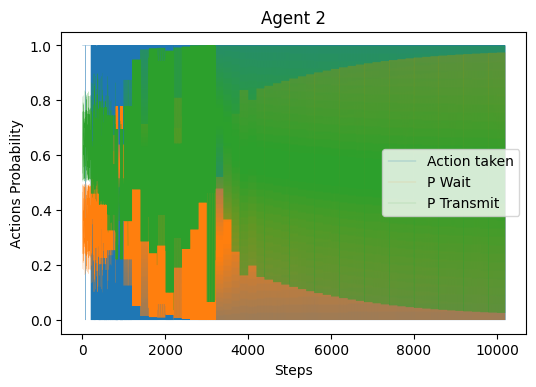

In [8]:
plt.plot(range(0,len(Q_value_1)),actions1, linewidth=0.2)
plt.plot(range(0,len(Q_value_1)),Q_value_1, linewidth=0.1)
plt.xlabel("Steps")
plt.ylabel("Actions Probability")
plt.legend(['Action taken','P Wait','P Transmit'])
plt.title('Agent 1')
plt.show()
plt.plot(range(0,len(Q_value_1)),actions2, linewidth=0.2)
plt.plot(range(0,len(Q_value_2)),Q_value_2, linewidth=0.1)
plt.xlabel("Steps")
plt.ylabel("Actions Probability")
plt.legend(['Action taken','P Wait','P Transmit'])
plt.title('Agent 2')
plt.show()

No handles with labels found to put in legend.


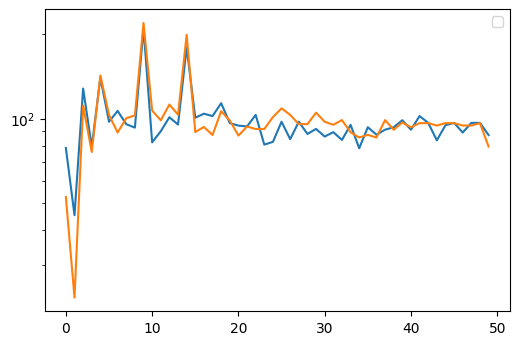

In [9]:
plt.semilogy(np.arange(len(losses2[0])), losses2[0])
plt.semilogy(np.arange(len(losses1[0])), losses1[0])
plt.legend()
plt.show()

In [10]:
'Run more slots for statistical collection'
agent1slots = 0
agent2slots = 0
collisions = 0
agent1clean = 0
agent2clean = 0
wasted = 0
slots = 0
for runs in range(0,10):
  #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
  for i in range(0,HISTORY_BUFFER_LEN):
    combine_state_history
    #epsilon = 0.9*epsilon

    #Change states
    'Both take random actions (epsilon = 1)'
    #agent 1
    action1 = agent1.choose_action(environment1._state, 0)
    if action1 == 1: #if i transmit or not
      state2 = np.append(state2, 1) #sensed from agent 2
      my_history1 = np.append(my_history1, 1)
      agent1slots += 1
      agent1transmit = 1
    else:
      state2 = np.append(state2, 0) 
      my_history1 = np.append(my_history1, 0)
      agent1transmit = 0

    state2 = np.delete(state2,0) #pop last in window
    my_history1 = np.delete(my_history1,0) #pop last in window

    #agent 2
    action2 = agent2.choose_action(environment2._state, 0)
    if action2 == 1:
      state1 = np.append(state1, 1) 
      my_history2 = np.append(my_history2, 1)
      agent2slots += 1
      agent2transmit = 1
    else:
      state1 = np.append(state1, 0) 
      my_history2 = np.append(my_history2, 0)
      agent2transmit = 0

    state1 = np.delete(state1,0) #pop last in window
    my_history2 = np.delete(my_history2,0) #pop last in window
    
    #set the new state
    environment1._state = combine_state_history(state1, my_history1)
    environment2._state = combine_state_history(state2, my_history2)

    DQN_input = tf.concat(environment1._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
    action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

    print('1 - state: ', environment1._state, 'agent online dqn: ', outputs, 'action:', action)


    reward1 = environment1.step(prv_action1, good_reward)
    reward2 = environment2.step(prv_action1, good_reward)

    agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
    agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
    
    if agent1transmit == 1 and agent2transmit == 1:
      collisions += 1
    if agent1transmit == 0 and agent2transmit == 1:
      agent2clean += 1
    if agent1transmit == 1 and agent2transmit == 0:
      agent1clean += 1
    if agent1transmit == 0 and agent2transmit == 0:
      wasted += 1
    #save PREVIOUS state and action
    prv_action1 = action1
    prv_action2 = action2
    prv_state1 = environment1._state
    prv_state2 = environment2._state
    slots += 1
  agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  if runs%10 == 0:
    agent1.copy_parameters()
    agent2.copy_parameters()
    print('episode: ', runs)

print('total time slots: ', slots)
print('agent 1 all transmit slots:', agent1slots)
print('agent 2 all transmit slots:', agent2slots)
print('Collisions: ', collisions)
print('agent 1 clean slots: ', agent1clean)
print('agent 2 clean slots: ', agent2clean)
print('wasted slots: ', wasted)

1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] action: 0
1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] action: 0
1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] action: 0
1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] action: 0
1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] action: 0
1 - state:  [0. 3. 0. 3.] agent online dqn:  [[1.4718294e-13 1.0000000e+00]] action: 1
1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8189245  0.18107551]] ac

In [11]:


DQN_input = tf.concat(environment1._state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('1 - state: ', environment1._state, 'agent online dqn: ', outputs, 'action:', action)

print('')

state =  [ 1, 2, 1, 2]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('1 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)
state =  [ 1, 2, 1, 2]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent2.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('2 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)


state =  [ 2, 1, 2, 1]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('1 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

state =  [ 2, 1, 2, 1]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent2.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('2 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

print('')

state =  [ 2, 2, 1, 1]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('1 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

state =  [ 2, 2, 1, 1]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent2.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1).

print('2 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

state =  [ 1, 1, 2, 2]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent1.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('1 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

state =  [ 1, 1, 2, 2]
DQN_input = tf.concat(state, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
outputs = agent2.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)

print('2 - state: ', state, 'agent online dqn: ', outputs, 'action:', action)

1 - state:  [3. 0. 3. 0.] agent online dqn:  [[0.8608156  0.13918443]] action: 0

1 - state:  [1, 2, 1, 2] agent online dqn:  [[1.2899578e-06 9.9999869e-01]] action: 1
2 - state:  [1, 2, 1, 2] agent online dqn:  [[2.8458056e-09 1.0000000e+00]] action: 1
1 - state:  [2, 1, 2, 1] agent online dqn:  [[0.5297897  0.47021028]] action: 0
2 - state:  [2, 1, 2, 1] agent online dqn:  [[0.68793625 0.31206375]] action: 0

1 - state:  [2, 2, 1, 1] agent online dqn:  [[0.73464155 0.26535848]] action: 0
2 - state:  [2, 2, 1, 1] agent online dqn:  [[0.00234823 0.99765176]] action: 1
1 - state:  [1, 1, 2, 2] agent online dqn:  [[1.4948771e-05 9.9998510e-01]] action: 1
2 - state:  [1, 1, 2, 2] agent online dqn:  [[3.9750040e-07 9.9999964e-01]] action: 1


In [12]:


plt.hist([rewards1[0],rewards1[1],rewards1[2],rewards1[3],rewards1[4],rewards1[5],rewards1[6],rewards1[7],rewards1[8],rewards1[9]],10,label=['2', '3','4', '5','6', '7','8', '9','10', '11','12'])
plt.legend()
plt.show()

plt.hist([rewards2[0],rewards2[1],rewards2[2],rewards2[3],rewards2[4],rewards2[5],rewards2[6],rewards2[7],rewards1[8],rewards1[9]],10,label=['2', '3','4', '5','6', '7','8', '9','10', '11','12'])
plt.legend()
plt.show()

IndexError: ignored